In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\jamie\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer usin

Epoch 1/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.1632 - loss: 3.0012 - val_accuracy: 0.3121 - val_loss: 2.3292
Epoch 2/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.3578 - loss: 2.0626 - val_accuracy: 0.4611 - val_loss: 1.8418
Epoch 3/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.4606 - loss: 1.7266 - val_accuracy: 0.5756 - val_loss: 1.4472
Epoch 4/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 0.5189 - loss: 1.5197 - val_accuracy: 0.6323 - val_loss: 1.2196
Epoch 5/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.5562 - loss: 1.3876 - val_accuracy: 0.6717 - val_loss: 1.0796
Epoch 6/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 16s 179ms/step - accuracy: 0.5885 - loss: 1.2784 - val_accuracy: 0.7068 - val_loss: 0.9895
Epoch 7/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - accuracy: 0.6173 - loss: 1.2069 - val_accuracy: 0.7106 - val_loss: 0.9314
Epoch 8/25
87/87 ━━━━━━━━━━━━━━━━━━━━ 15s 176ms/step - accuracy: 0.6406 - loss: 1.1321 - val_accu

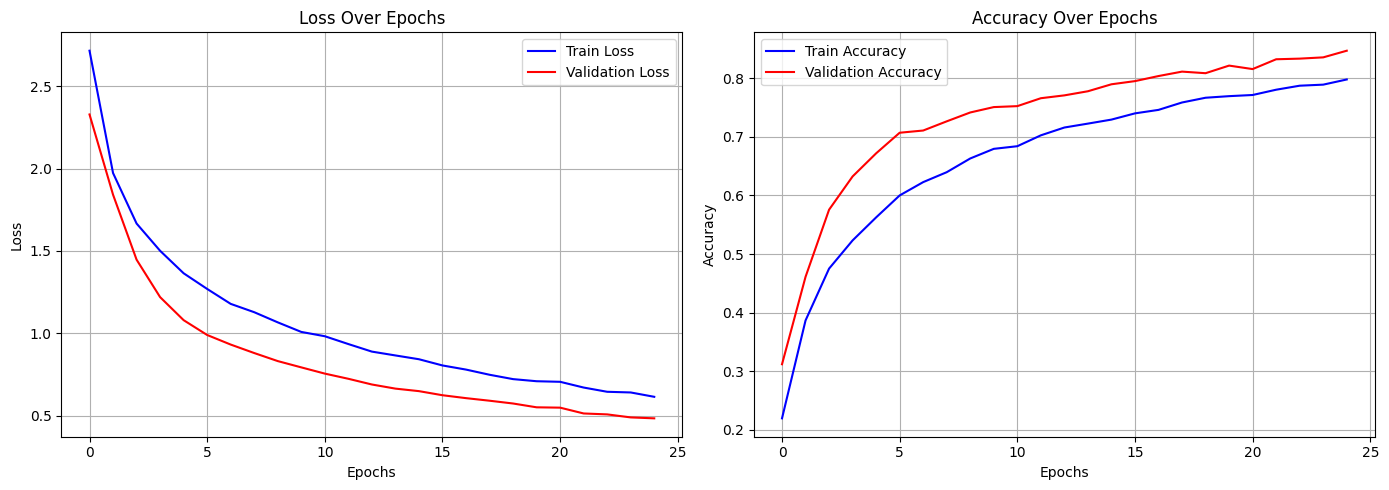

58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
Classification Report:
                precision    recall  f1-score   support

   Brush_teeth       0.92      0.97      0.94       125
  Climb_stairs       0.80      0.33      0.47       148
     Comb_hair       0.95      0.98      0.96       125
Descend_stairs       0.82      0.81      0.81       144
   Drink_glass       0.94      0.94      0.94       125
      Eat_meat       0.84      0.98      0.90       139
      Eat_soup       0.96      1.00      0.98       129
     Getup_bed       0.87      0.64      0.74       132
   Liedown_bed       0.95      0.99      0.97       143
    Pour_water       0.87      0.88      0.87       126
 Sitdown_chair       0.86      0.84      0.85       140
 Standup_chair       0.82      0.87      0.85       132
 Use_telephone       0.96      0.96      0.96       134
          Walk       0.43      0.72      0.54       110

      accuracy                           0.85      1852
     macro avg       0.86      0.85    

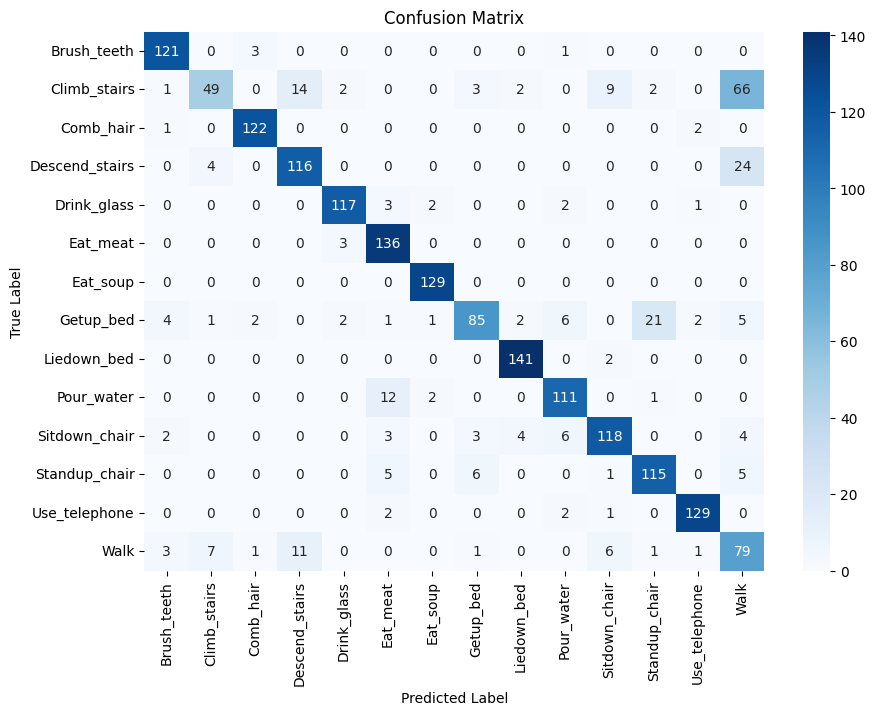

In [ ]:
# Load the dataset
data_path = "../Datasets/downsampled_activity_dataset.csv"
df = pd.read_csv(data_path)

# Define timestep size
timestep_size = 125  # Each timestep consists of 125 rows

# Prepare sequences
x_data, y_data = [], []

for event_id, event_data in df.groupby("eventId"):
    sequences = event_data[["x", "y", "z", "magnitude" ]].values
    labels = event_data["label"].values
    
    # Split into 125-row timesteps
    for i in range(0, len(sequences) - timestep_size + 1, timestep_size):
        x_data.append(sequences[i:i + timestep_size])
        y_data.append(labels[i])  # Assign the first label in the segment

x_data = np.array(x_data)  # Shape: (num_timesteps, 125, 4)
y_data = np.array(y_data)

# Encode labels
label_encoder = LabelEncoder()
y_data_encoded = label_encoder.fit_transform(y_data)
y_data_encoded = to_categorical(y_data_encoded, num_classes=len(label_encoder.classes_))

# Reshape for oversampling
x_data_reshaped = x_data.reshape(x_data.shape[0], -1)

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
x_resampled, y_resampled = ros.fit_resample(x_data_reshaped, np.argmax(y_data_encoded, axis=1))

# Reshape back to original format
x_resampled = x_resampled.reshape(-1, timestep_size, 4)
y_resampled = to_categorical(y_resampled, num_classes=len(label_encoder.classes_))

# Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=333)

# Build the LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(timestep_size, 4)),
    BatchNormalization(),
    Dropout(0.2),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../Models/Early_Stopping/best_model.keras', save_best_only=True)

history = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test), 
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0].set_title('Loss Over Epochs')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[1].set_title('Accuracy Over Epochs')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

# Predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

model.save('../Models/activity_model.keras')
